# Wind Farm Test
In this file, one can test certain wind farm layouts and configurations. Some basic functions are demonstrated. With the resulting turbine power outputs and flowfields, one can make their own comparisons between farms.

### Import libraries
Here, the libraries used in this file are imported.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from scipy.interpolate import interp1d
from scipy import optimize

# Import custom libraries
import functions as func
import visualization as viz
import optimization as opt
from optimization import Optimization
from models import (
    LES,
    CCM,
    TestModel,
)
from cases import (
    Case,
    CaseManager,
)

# Get some of the most beautiful color schemes you've ever seen
colors, colorgrad = viz.get_color_schemes()

### Create case manager

In [2]:
# Add new case
test_casemanager = CaseManager(
    name='Test Case Manager',
    ref_model=LES,
    ref_data_location='../LES/',
    ref_standard_case='1TURB_wd270_ws10_1x_y0_t5',
)

# Set masks to select cases from csv-file
masks = {
    'test': 1,
    'optimization': 1,
}

# Load csv files
test_casemanager.load_csv_cases(
    location='../TouchWind_Optimization_Framework/',
    file_name='test_cases.csv',
    masks=masks,
    model=CCM(),
)

x_i and y_i set to predefined values
x_i and y_i set to predefined values
x_i and y_i set to predefined values
x_i and y_i set to predefined values


In [17]:
test_casemanager.cases['2x2TURB_wd270_ws10_4x_y0_t5'].__dict__

{'name': '2x2TURB_wd270_ws10_4x_y0_t5',
 'model': <models.CCM at 0x1a6bd173a10>,
 'layout': {'shape': 'rectangular',
  'n_x': 2,
  'n_y': 2,
  'x_i': array([ 500, 1130,  500, 1130], dtype=int64),
  'y_i': array([315, 315, 945, 945], dtype=int64),
  'n_turbines': 4},
 'conditions': {'directions': [270],
  'speeds': [10],
  'TI': array([0.06]),
  'ABL_params': None},
 'turbines': {'yaw_i': array([0., 0., 0., 0.]),
  'tilt_i': array([5., 5., 5., 5.]),
  'CT_i': None,
  'D_rotor_i': 126},
 'turbine_powers': array([[[3816327.47741501, 1342181.6755733 , 3816327.47741501,
          1342181.6755733 ]]])}

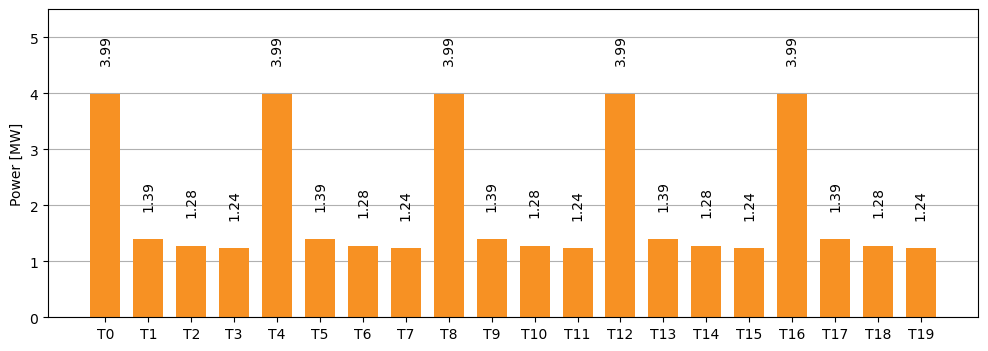

In [39]:
# Create instance of case
custom_case_1 = Case(
    name='custom_case_1',
    model=CCM(),
)

# Set conditions
custom_case_1.set_conditions(
    directions=np.array([270]),
    speeds=np.array([10]),
    TI=np.array([0.06]),
    ABL_params=None,
)

# Set wind farm layout
custom_case_1.set_layout(
    shape='rectangular',
    n_x=4,
    n_y=5,
    spacing_x=5,
    spacing_y=5,
    D_rotor=126,
    x_i=None, 
    y_i=None,
)

# Set turbine properties
custom_case_1.set_turbines(
    yaw_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0,
    tilt_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0,
    CT_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0.5,
)

# Run case and plot powers
turbine_powers = custom_case_1.run()
viz.plot_turbine_powers(turbine_powers[0, 0])

### Run cases

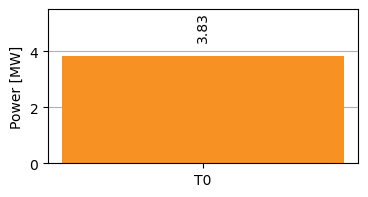

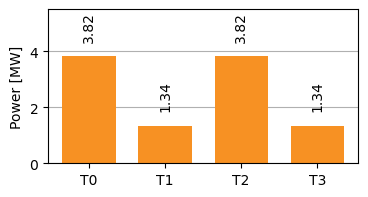

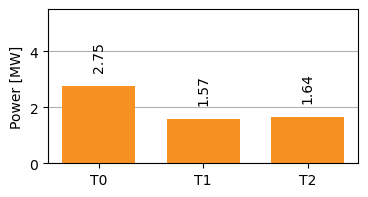

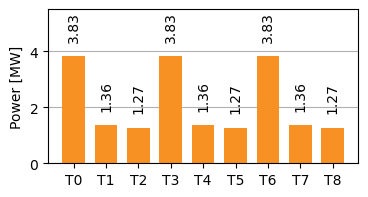

In [3]:
cases = test_casemanager.get_cases()

for idc, c in enumerate(cases):
    turbine_powers = c.run()
    viz.plot_turbine_powers(turbine_powers[0, 0], figsize=(4, 2))

### Optimization

In [13]:
# Optimization algorithm

# Select case for optimization
case_name = '3x3_optimization_test'
optimization_case = copy.deepcopy(test_casemanager.cases[case_name])

# Select parameters to optimize
optimization_parameters = [
    'yaw',
    'tilt',
    'C_t',
]

# Set location and file name of resulting data
result_location = '../Optimization Results/'
result_filename = f'{case_name}.csv'

# Set optimization algorithm settings
method = 'SLSQP'
penalty = True
options = {
    'disp': True,
    'maxiter': 100,
    'eps': None,
}
tolerance = 1e-2

# Set wind directions and uncertainty parameters
wind_directions = np.linspace(225, 312, 30)
wind_speeds = np.linspace(10, 10, 1)
exclude_range = 120
n_discretized_wds = 7
sigma_wd = 5.25

# Set wind turbine properties
bounds = {
    'yaw': (-40, 40),
    'tilt': (-50, -5),
    'C_t': (0, 1),
}
guesses = {
    'yaw': 0,
    'tilt': -5,
    'C_t': 1,
}
downwind_values = guesses

# Get number of turbines
n_turbines = optimization_case.layout['n_turbines']

# Initialize dataframe for wind farm data
df_optimization = opt.get_optimization_dataframe(
    result_location,
    result_filename,
    optimization_parameters,
    optimization_case.layout,
)

# Get downwind mask for all wind directions
downwind_masks = func.get_downwind_masks(
    wind_directions,
    optimization_case.layout,
    exclude_range,
)

# Get parameter names, bounds and guesses dictionaries corresponding with result lists
result_bounds_guess_dicts = opt.get_result_bounds_guess_dicts(
    optimization_parameters,
    downwind_masks,
    bounds,
    guesses,
)

# TODO: Get conventional total powers
turbine_powers_conv = opt.get_turbine_powers_conv(
    optimization_case,
    wind_directions,
    downwind_values,
)
total_powers_conv = np.sum(turbine_powers_conv, axis=2)[:, 0]

# Start optimization framework
start_time = time.time()

for idw, wd in enumerate(wind_directions):
    # Get conventional total power
    total_power_conv = total_powers_conv[idw]

    # Get lists of parameter names, bounds and guesses
    dictionary = result_bounds_guess_dicts[idw]
    parameter_names = list(dictionary.keys())
    parameter_bounds = [i[0] for i in list(dictionary.values())]
    parameter_guesses = [i[1] for i in list(dictionary.values())]

    # Initialize optimization class for wind direction
    optimization = Optimization(
        case=optimization_case,
        wd=wd,
        vars=optimization_parameters,
        mask=downwind_masks[idw],
        method=method,
        penalty=penalty,
        total_power_conv=total_power_conv,
        downwind_values=downwind_values,
        n_particles=1,
        n_discretized_wds=n_discretized_wds,
        sigma_wd=sigma_wd,
    )

    # Run optimization algorithm
    start_time_wd = time.time()

    result = optimize.minimize(
        fun=optimization.cost_function,
        x0=parameter_guesses,
        tol=tolerance,
        bounds=parameter_bounds,
        options=options,
    )

    end_time_wd = time.time()

    # Get optimized wind turbine parameter set
    parameters_optimized = result.x

    # Get complete wind turbine parameter set
    all_parameters = opt.get_all_parameters(
        n_turbines,
        parameter_names,
        parameters_optimized,
        optimization_parameters,
        downwind_values,
    )

    # Get total power and turbine powers
    total_power = optimization.total_power
    turbine_powers = optimization.turbine_powers

    # Save wind farm data in new row dictionary
    dict_new_row =  all_parameters.copy()
    dict_new_row['wind_direction'] = wd
    dict_new_row['total_power'] = total_power
    dict_new_row['total_power_conv'] = total_power_conv
    dict_new_row['time'] = end_time_wd - start_time_wd
    dict_new_row['success'] = result.success
    dict_new_row['message'] = result.message
    dict_new_row['n_iterations'] = result.nit
    dict_new_row['function_values'] = optimization.function_values
    dict_new_row['result'] = result
    
    for turb in range(n_turbines):
        dict_new_row[f'power_{turb}'] = turbine_powers[turb]
    
    # Add new row to dataframe
    df_new_row = pd.DataFrame([dict_new_row])
    df_optimization = pd.concat([df_optimization, df_new_row], ignore_index=True)
    
    # Save optimization data
    # df_optimization.to_csv(result_location + result_filename, index=False)

    # Print progress and estimated time
    opt.print_progress(
        start_time,
        idw,
        wind_directions,
    )

# TODO save settings in txt file

Progress: 40.0 %
    Mean time per optimization run: 0.0 minutes
    Estimation: 0 minutes remaining
    Currently at wind direction 258.0 (12 of 30)


### Visualization

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_optimization)):
    values = df_optimization['function_values'].iloc[i] / df_optimization['function_values'].iloc[i][0]
    ax.plot(values, color=colorgrad[i%len(colorgrad)])
    ax.scatter(len(values), values[-1], color=colorgrad[i%len(colorgrad)])
ax.set_xlabel('Iteration [-]')
ax.set_ylabel('$P/P_{CONV}$ [-]')
ax.grid()
ax.set_xlim(0,)
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['total_power_conv']/1e6, color=colors[0], label='CONV', marker='o')
ax.plot(df_optimization['wind_direction'], df_optimization['total_power']/1e6, color=colors[1], label='OPT', marker='s')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Power [MW]')
ax.grid()
ax.legend()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

In [ ]:
value = 'yaw'

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for turb in range(n_turbines):
    if value == 'power':
        ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}']/1e6, color=colorgrad[turb%len(colorgrad)])
    else:
        ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}'], color=colorgrad[turb%len(colorgrad)])
ax.set_xlabel('Wind direction [°]')
if value == 'power':
    ax.set_ylabel('Power [MW]')
elif value == 'yaw':
    ax.set_ylabel('Yaw angle [°]')
elif value == 'tilt':
    ax.set_ylabel('Tilt angle [°]')
elif value == 'C_t':
    ax.set_ylabel('Thrust coefficient [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['time'], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Time [s]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], [len(i) for i in df_optimization['function_values']], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Number of function evaluations [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['n_iterations'], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Number of iterations [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

### Optimization iteration study

### TEST

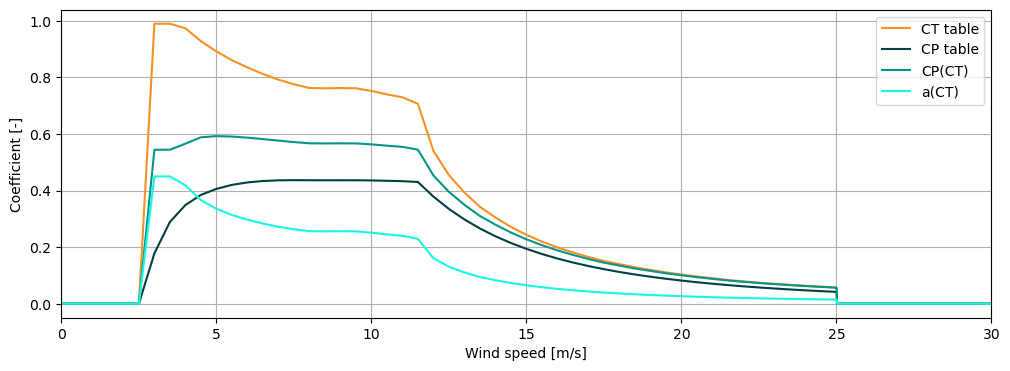

In [5]:
power_coef = - np.array([
    - 0.0,
    - 0.000000,
    - 0.000000,
    - 0.178085,
    - 0.289075,
    - 0.349022,
    - 0.384728,
    - 0.406059,
    - 0.420228,
    - 0.428823,
    - 0.433873,
    - 0.436223,
    - 0.436845,
    - 0.436575,
    - 0.436511,
    - 0.436561,
    - 0.436517,
    - 0.435903,
    - 0.434673,
    - 0.433230,
    - 0.430466,
    - 0.378869,
    - 0.335199,
    - 0.297991,
    - 0.266092,
    - 0.238588,
    - 0.214748,
    - 0.193981,
    - 0.175808,
    - 0.159835,
    - 0.145741,
    - 0.133256,
    - 0.122157,
    - 0.112257,
    - 0.103399,
    - 0.095449,
    - 0.088294,
    - 0.081836,
    - 0.075993,
    - 0.070692,
    - 0.065875,
    - 0.061484,
    - 0.057476,
    - 0.053809,
    - 0.050447,
    - 0.047358,
    - 0.044518,
    - 0.041900,
    - 0.039483,
    - 0.0,
    - 0.0,
])

thrust_coef = - np.array([
    - 0.0,
    - 0.0,
    - 0.0,
    - 0.99,
    - 0.99,
    - 0.97373036,
    - 0.92826162,
    - 0.89210543,
    - 0.86100905,
    - 0.835423,
    - 0.81237673,
    - 0.79225789,
    - 0.77584769,
    - 0.7629228,
    - 0.76156073,
    - 0.76261984,
    - 0.76169723,
    - 0.75232027,
    - 0.74026851,
    - 0.72987175,
    - 0.70701647,
    - 0.54054532,
    - 0.45509459,
    - 0.39343381,
    - 0.34250785,
    - 0.30487242,
    - 0.27164979,
    - 0.24361964,
    - 0.21973831,
    - 0.19918151,
    - 0.18131868,
    - 0.16537679,
    - 0.15103727,
    - 0.13998636,
    - 0.1289037,
    - 0.11970413,
    - 0.11087113,
    - 0.10339901,
    - 0.09617888,
    - 0.09009926,
    - 0.08395078,
    - 0.0791188,
    - 0.07448356,
    - 0.07050731,
    - 0.06684119,
    - 0.06345518,
    - 0.06032267,
    - 0.05741999,
    - 0.05472609,
    - 0.0,
    - 0.0,
])

velocity = - np.array([
    - 0.0,
    - 2.0,
    - 2.5,
    - 3.0,
    - 3.5,
    - 4.0,
    - 4.5,
    - 5.0,
    - 5.5,
    - 6.0,
    - 6.5,
    - 7.0,
    - 7.5,
    - 8.0,
    - 8.5,
    - 9.0,
    - 9.5,
    - 10.0,
    - 10.5,
    - 11.0,
    - 11.5,
    - 12.0,
    - 12.5,
    - 13.0,
    - 13.5,
    - 14.0,
    - 14.5,
    - 15.0,
    - 15.5,
    - 16.0,
    - 16.5,
    - 17.0,
    - 17.5,
    - 18.0,
    - 18.5,
    - 19.0,
    - 19.5,
    - 20.0,
    - 20.5,
    - 21.0,
    - 21.5,
    - 22.0,
    - 22.5,
    - 23.0,
    - 23.5,
    - 24.0,
    - 24.5,
    - 25.0,
    - 25.01,
    - 25.02,
    - 50.0,
])

ai = 1 / 2 * (1 - np.sqrt(1 - thrust_coef))

CP = 4 * ai * (1 - ai)**2

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(velocity, thrust_coef, color=colors[0], label='CT table')
ax.plot(velocity, power_coef, color=colors[1], label='CP table')
ax.plot(velocity, CP, color=colors[2], label='CP(CT)')
ax.plot(velocity, ai, color=colors[3], label='a(CT)')
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Coefficient [-]')
ax.grid()
ax.legend()
ax.set_xlim(0, 30)
plt.show()

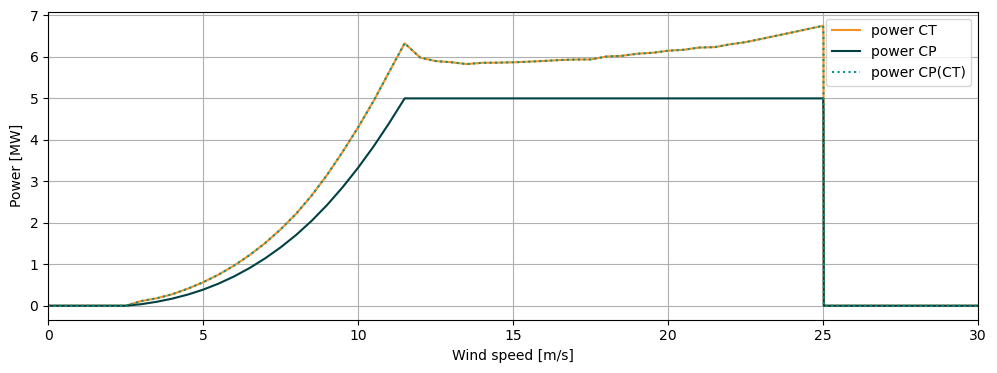

In [6]:
rho = 1.225
A = np.pi * (126/2)**2

power_cp = 1 / 2 * rho * A * velocity**3 * power_coef
power_cpct = 1 / 2 * rho * A * velocity**3 * CP
power_ct = 2 * rho * A * velocity**3 * ai * (1 - ai)**2

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(velocity, power_ct/1e6, color=colors[0], label='power CT')
ax.plot(velocity, power_cp/1e6, color=colors[1], label='power CP')
ax.plot(velocity, power_cpct/1e6, color=colors[2], label='power CP(CT)', linestyle=':')
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Power [MW]')
ax.grid()
ax.legend()
ax.set_xlim(0, 30)
plt.show()

In [7]:
p_model = c.model.farm.floris.farm.turbine_power_interps['nrel_5MW_initial'](5)

velocity5 = 5
thrust_coef5 = 0.89210543
power_coef5 = 0.406059

fCt_Cp_interp = interp1d(
    thrust_coef,
    power_coef,
    fill_value=(0.0, 1.0),
    bounds_error=False,
)

power_coefCt = fCt_Cp_interp(thrust_coef5)

p_new = 1 / 2 * A * velocity5**3 * power_coefCt

p_model, p_new, 316446.37838656

(array(316446.37838656), 316446.37838656415)